In [105]:
!pip install -q transformers

In [106]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

import tensorflow as tf
import json

import numpy as np
import pandas as pd

import os
import re

In [107]:
jsonDataString = "{"
DataTypes = []
EmotionData= []
dataDir = ["data/"]
for dataList in dataDir:
  for dirNames in os.listdir(os.path.join(dataList)):
    jsonDataString+=dirNames+':[{'
    temp2 = ""
    for emoDir in os.listdir(os.path.join(dataList,dirNames)):
      jsonDataString += emoDir+':['
      for filesName in os.listdir(os.path.join(dataList,dirNames,emoDir)):
        with open(os.path.join(dataList,dirNames,emoDir, filesName) ,'r') as f:
          jsonDataString+=re.sub(r"\n", "", f.read())+','
          
      jsonDataString = jsonDataString[0:len(jsonDataString)-1]+'],'
    jsonDataString =jsonDataString[0:len(jsonDataString)-1]+'}],'
  

      # for filesName in os.listdir(os.path.join(dataList,dirNames,emoDir)):
      #   print('',end='')
    #with open(os.path.join(os.getcwd(), filename), 'r') as f:
jsonDataString = jsonDataString[0:len(jsonDataString)-1]+'}' 
print(jsonDataString)

In [108]:
TestTrainData = json.load(open('/home/data.json'))
TrainData = TestTrainData['train'][0]
TestData = TestTrainData['test'][0]
FormattedTrainData=[]
FormattedTrainLabel=[]
FormattedTestData=[]
FormattedTestLabel=[]

for i in ((TestData)):
  # if((list((TestData.keys())).index(i))<2):
  for ii in TestData[i]:
      FormattedTestData.append([(list((TestData.keys())).index(i)),ii])
      FormattedTestLabel.append(((list((TrainData.keys())).index(i))))

for i in ((TrainData)):
  # if((list((TrainData.keys())).index(i))<2):
  for ii in TrainData[i]:
        FormattedTrainData.append([(list(TrainData.keys()).index(i)),ii])
        FormattedTrainLabel.append((list(TrainData.keys()).index(i)))

FormattedTrainData = pd.DataFrame(np.array((FormattedTrainData)), columns = ['label','message']).sample(frac = 1)
FormattedTestData =  pd.DataFrame(np.array((FormattedTestData)), columns = ['label','message']).sample(frac = 1)
FormattedTrainData.head()
FormattedTestData.head()

,label,message
545,2,i get frustrated that unresolved issues from m...
286,1,ive got to learn to be mindful of how i feel a...
490,2,i didnt want to be spending my days working in...
256,1,i feel agitated and annoyed more than worried ...
90,0,i feel that i am supporting the troops by dema...


In [109]:
print(FormattedTrainData['label'])


766     0
6710    3
8327    3
3209    1
7193    3
       ..
2655    1
2354    1
6067    3
7209    3
6945    3
Name: label, Length: 8687, dtype: object


In [110]:
training_sentences = list(FormattedTrainData['message'])
validation_sentences = list(FormattedTestData['message'])
training_labels = list(pd.to_numeric(FormattedTrainData['label'], downcast='integer'))
validation_labels =  list(pd.to_numeric(FormattedTestData['label'], downcast='integer'))

print(type(training_labels[0]))

<class 'int'>


In [111]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)


In [112]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
))


In [113]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=4)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_59', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [114]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
hist = model.fit(train_dataset.batch(128),
          epochs=1,
          batch_size=128,
          validation_data=val_dataset.shuffle(100).batch(128))

68/68 [==============================] - 146s 2s/step - loss: 0.7028 - accuracy: 0.7202 - val_loss: 0.1916 - val_accuracy: 0.9380


In [115]:
model.summary()

model.save_pretrained('/home/emotion_Model')

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
 dropout_59 (Dropout)        multiple                  0         
                                                                 
Total params: 66,956,548
Trainable params: 66,956,548
Non-trainable params: 0
_________________________________________________________________


In [116]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("/home/emotion_Model")

Some layers from the model checkpoint at /home/emotion_Model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_59']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /home/emotion_Model and are newly initialized: ['dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [117]:

predict_output=[]
for i in validation_sentences:
  predict_input = tokenizer.encode(i,
                                  truncation=True,
                                  padding=True,
                                  return_tensors="tf")
  tf_output = loaded_model.predict(predict_input)[0]
  tf_prediction = list(tf.nn.softmax(tf_output)[0].numpy())
  predition = tf_prediction.index(max(list(tf_prediction)))
  predict_output.append(list(TestData)[predition])
print(predict_output)

['Anger', 'Fear', 'Sadness', 'Anger', 'Love', 'Sadness', 'Fear', 'Fear', 'Anger', 'Sadness', 'Sadness', 'Sadness', 'Love', 'Anger', 'Sadness', 'Anger', 'Anger', 'Anger', 'Sadness', 'Anger', 'Sadness', 'Sadness', 'Fear', 'Sadness', 'Fear', 'Sadness', 'Anger', 'Fear', 'Anger', 'Anger', 'Sadness', 'Anger', 'Love', 'Love', 'Anger', 'Sadness', 'Sadness', 'Sadness', 'Anger', 'Sadness', 'Anger', 'Fear', 'Anger', 'Sadness', 'Fear', 'Sadness', 'Anger', 'Anger', 'Anger', 'Sadness', 'Sadness', 'Love', 'Sadness', 'Anger', 'Fear', 'Sadness', 'Sadness', 'Love', 'Sadness', 'Anger', 'Fear', 'Love', 'Anger', 'Fear', 'Sadness', 'Sadness', 'Sadness', 'Love', 'Sadness', 'Fear', 'Love', 'Fear', 'Fear', 'Sadness', 'Love', 'Sadness', 'Love', 'Sadness', 'Love', 'Sadness', 'Anger', 'Sadness', 'Anger', 'Fear', 'Love', 'Sadness', 'Love', 'Anger', 'Fear', 'Anger', 'Fear', 'Sadness', 'Sadness', 'Love', 'Sadness', 'Love', 'Anger', 'Sadness', 'Sadness', 'Fear', 'Sadness', 'Sadness', 'Fear', 'Sadness', 'Sadness', 'Sa

In [118]:
true_output = []
for i in list(pd.to_numeric(validation_labels)):
  true_output.append(list(TestData)[i])
print(true_output)

# print(tf_prediction)
# print(TestData.keys())
# print(TrainData.keys())

['Anger', 'Fear', 'Anger', 'Fear', 'Love', 'Sadness', 'Anger', 'Fear', 'Anger', 'Sadness', 'Love', 'Sadness', 'Sadness', 'Anger', 'Sadness', 'Anger', 'Anger', 'Anger', 'Sadness', 'Anger', 'Sadness', 'Sadness', 'Fear', 'Sadness', 'Fear', 'Sadness', 'Anger', 'Fear', 'Sadness', 'Anger', 'Sadness', 'Anger', 'Love', 'Love', 'Anger', 'Sadness', 'Sadness', 'Sadness', 'Anger', 'Sadness', 'Anger', 'Fear', 'Anger', 'Sadness', 'Fear', 'Sadness', 'Anger', 'Anger', 'Anger', 'Sadness', 'Sadness', 'Love', 'Sadness', 'Anger', 'Fear', 'Sadness', 'Sadness', 'Love', 'Sadness', 'Sadness', 'Fear', 'Love', 'Anger', 'Fear', 'Sadness', 'Sadness', 'Sadness', 'Love', 'Sadness', 'Fear', 'Love', 'Fear', 'Fear', 'Sadness', 'Love', 'Sadness', 'Love', 'Sadness', 'Love', 'Sadness', 'Anger', 'Sadness', 'Sadness', 'Fear', 'Love', 'Sadness', 'Love', 'Anger', 'Fear', 'Sadness', 'Fear', 'Sadness', 'Sadness', 'Love', 'Sadness', 'Love', 'Anger', 'Sadness', 'Sadness', 'Fear', 'Sadness', 'Sadness', 'Fear', 'Sadness', 'Sadness

In [119]:
from sklearn.metrics import f1_score
f1_score(true_output, pimport matplotlib.pyplot as pltredict_output, average='macro')

0.9347499127624602

In [132]:
!pip install --upgrade seaborn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns


# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')



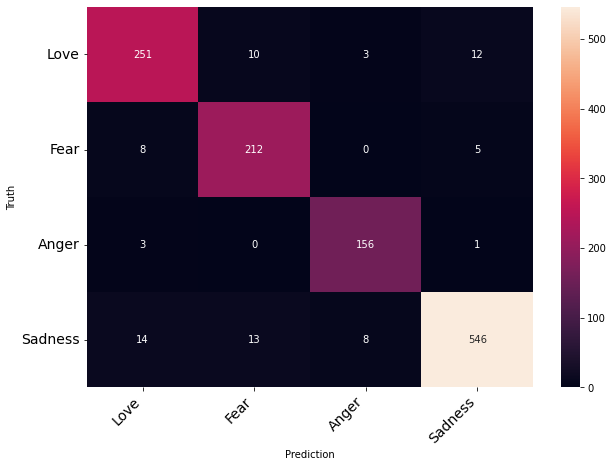

In [133]:
val = confusion_matrix(true_output,predict_output)  
print_confusion_matrix(val,TestData.keys())